# Step 1 - Model Training

Keras를 통해 모델을 설계한다. 

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Lambda, Input, concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ELU
from keras.optimizers import Adam, SGD, Adamax, Nadam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, CSVLogger, EarlyStopping
import keras.backend as K
from keras.preprocessing import image

from keras_tqdm import TQDMNotebookCallback

import json
import os
import numpy as np
import pandas as pd
from Generator import DriveDataGenerator
from Cooking import checkAndCreateDir
import h5py
from PIL import Image, ImageDraw
import math
import matplotlib.pyplot as plt

#GPU Memory Error
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

# << The directory containing the cooked data from the previous step >>
COOKED_DATA_DIR = 'E:/Airsim_data/data_cooked/'

# << The directory in which the model output will be placed >>
MODEL_OUTPUT_DIR = 'model'

Using TensorFlow backend.


Let's read in the datasets from the exploration phase. If these do not exist, run the snippet from the [previous](DataExplorationAndPreparation.ipynb) notebook to generate them.

In [2]:
train_dataset = h5py.File(os.path.join(COOKED_DATA_DIR, 'train.h5'), 'r')
eval_dataset = h5py.File(os.path.join(COOKED_DATA_DIR, 'eval.h5'), 'r')
test_dataset = h5py.File(os.path.join(COOKED_DATA_DIR, 'test.h5'), 'r')

num_train_examples = train_dataset['image'].shape[0]
num_eval_examples = eval_dataset['image'].shape[0]
num_test_examples = test_dataset['image'].shape[0]

batch_size=32

이미지 데이터의 경우, 전체 데이터 셋을 로드하기에 너무 많은 리소스가 소모되기 때문에, Chunks로 데이터를 읽는다.
그리고, 데이터 전처리 때 언급했었던 데이터 학습을 효율적으로 하기 위해 몇 가지의 전략을 적용했다.


* **ROI를 통해 필요한 부분만 학습** - 배치로 이미지를 처리할 때, 불필요한 부분은 없애고 처리함
* **데이터 셋은 수직(Vertical) 플립으로 표시** - 배치로 이미지를 처리할 때, Y축을 중심으로 임의의 이미지와 라벨을 플립하여, 모델은 그것으로부터 새로운 데이터를 생성한다. 
* **데이터 셋은 밝기와 관계없이 학습** - 이미지는 0.4로 밝기를 높여, 이미지의 밝기에 따라 장애물의 식별이 불가능한 경우를 제거한다.
* **데이터 셋의 조향 각도가 0이 많아, 다운 샘플링** - 배치로 이미지를 처리할 때, 0의 빈도가 상당히 많으므로, 일정 비율로 처리하여 학습을 진행한다.
* **swerve의 데이터를 활용하여, 탈선 등을 방지** - 데이터 전처리 과정에서 상세한 설명 참조

주요 매개변수
* **Zero_Drop_Percentage: 0.8** - Label=0 인 데이터 요소의 80%를 임의로 삭제한다.
* **Brighten_Range: 0.4** - 각 이미지의 밝기를 최대 40% 높인다.
* **ROI: [76,135,0,255]** - ROI의 영역 지정을 한다.

In [3]:
data_generator = DriveDataGenerator(rescale=1./255., horizontal_flip=True, brighten_range=0.4)
train_generator = data_generator.flow\
    (train_dataset['image'], train_dataset['previous_state'], train_dataset['label'], batch_size=batch_size, zero_drop_percentage=0.8, roi=[76,135,0,255])
eval_generator = data_generator.flow\
    (eval_dataset['image'], eval_dataset['previous_state'], eval_dataset['label'], batch_size=batch_size, zero_drop_percentage=0.8, roi=[76,135,0,255])

샘플 Batch 이미지를 볼 수 있다.

Actual Steering Angle = [0.11920867]


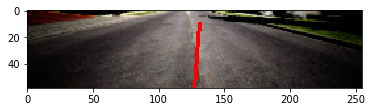

Actual Steering Angle = [0.17780233]


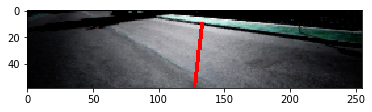

Actual Steering Angle = [-0.02766333]


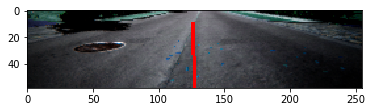

In [4]:
def draw_image_with_label(img, label, prediction=None):
    theta = label * 0.69 #Steering range for the car is +- 40 degrees -> 0.69 radians
    line_length = 50
    line_thickness = 3
    label_line_color = (255, 0, 0)
    prediction_line_color = (0, 0, 255)
    pil_image = image.array_to_img(img, K.image_data_format(), scale=True)
    print('Actual Steering Angle = {0}'.format(label))
    draw_image = pil_image.copy()
    image_draw = ImageDraw.Draw(draw_image)
    first_point = (int(img.shape[1]/2),img.shape[0])
    second_point = (int((img.shape[1]/2) + (line_length * math.sin(theta))), int(img.shape[0] - (line_length * math.cos(theta))))
    image_draw.line([first_point, second_point], fill=label_line_color, width=line_thickness)
    
    if (prediction is not None):
        print('Predicted Steering Angle = {0}'.format(prediction))
        print('L1 Error: {0}'.format(abs(prediction-label)))
        theta = prediction * 0.69
        second_point = (int((img.shape[1]/2) + (line_length * math.sin(theta))), int(img.shape[0] - (line_length * math.cos(theta))))
        image_draw.line([first_point, second_point], fill=prediction_line_color, width=line_thickness)
    
    del image_draw
    plt.imshow(draw_image)
    plt.show()

[sample_batch_train_data, sample_batch_test_data] = next(train_generator)
for i in range(0, 3, 1):
    draw_image_with_label(sample_batch_train_data[0][i], sample_batch_test_data[i])

네트워크 아키텍처를 정의한다. 이미지를 처리하기 위해 컨볼루션(Convolution) / 맥스 풀링(Max pooling) 레이어를 사용한다. 다음 차량의 상태를 나타내는 레이어를 삽입한다.

In [5]:
image_input_shape = sample_batch_train_data[0].shape[1:]
state_input_shape = sample_batch_train_data[1].shape[1:]
activation = 'relu'

#Create the convolutional stacks
pic_input = Input(shape=image_input_shape)

img_stack = Conv2D(16, (3, 3), name="convolution0", padding='same', activation=activation)(pic_input)
img_stack = MaxPooling2D(pool_size=(2,2))(img_stack)
img_stack = Conv2D(32, (3, 3), activation=activation, padding='same', name='convolution1')(img_stack)
img_stack = MaxPooling2D(pool_size=(2, 2))(img_stack)
img_stack = Conv2D(32, (3, 3), activation=activation, padding='same', name='convolution2')(img_stack)
img_stack = MaxPooling2D(pool_size=(2, 2))(img_stack)
img_stack = Flatten()(img_stack)
img_stack = Dropout(0.2)(img_stack)

#Inject the state input
state_input = Input(shape=state_input_shape)
merged = concatenate([img_stack, state_input])

# Add a few dense layers to finish the model
merged = Dense(64, activation=activation, name='dense0')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(10, activation=activation, name='dense2')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(1, name='output')(merged)

adam = Nadam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model = Model(inputs=[pic_input, state_input], outputs=merged)
model.compile(optimizer=adam, loss='mse')

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


완성된 모델을 보면 다음과 같다.

In [6]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 59, 255, 3)   0                                            
__________________________________________________________________________________________________
convolution0 (Conv2D)           (None, 59, 255, 16)  448         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 29, 127, 16)  0           convolution0[0][0]               
__________________________________________________________________________________________________
convolution1 (Conv2D)           (None, 29, 127, 32)  4640        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

Keras에서 제공하는 콜백 기능을 선언한다. 이것은 epoch 가 끝난 후에 실행된다.

* **ReduceLrOnPlateau** - 모델이 최소 시점에 있거나, 학습률이 너무 높으면 모델은 그 최소 주변에 머문다. 이는 유효성 검사 손실이 개선되지 않으면 최적의 시점에 마칠 수 있도록하여 학습률을 낮춘다.
* **CsvLogger** - 각 epoch 후에 모델의 출력을 로그로 기록한다. 콘솔이 없이도, 진행 상황을 알 수 있다.
* **ModelCheckpoint** - 일반적으로 검증 단계에서 손실이 가장 작은 모델을 사용하고, 개선될 때마다 모델을 저장한다.
* **EarlyStopping** - 손실이 줄지 않으면, 교육을 중단한다. 

In [7]:
plateau_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001, verbose=1)
checkpoint_filepath = os.path.join(MODEL_OUTPUT_DIR, 'models', '{0}_model.{1}-{2}.h5'.format('model', '{epoch:02d}', '{val_loss:.7f}'))
checkAndCreateDir(checkpoint_filepath)
checkpoint_callback = ModelCheckpoint(checkpoint_filepath, save_best_only=True, verbose=1)
csv_callback = CSVLogger(os.path.join(MODEL_OUTPUT_DIR, 'training_log.csv'))
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
callbacks=[plateau_callback, csv_callback, checkpoint_callback, early_stopping_callback, TQDMNotebookCallback()]


실제 모델 학습을 시작한다.

In [8]:
history = model.fit_generator(train_generator, steps_per_epoch=num_train_examples//batch_size, epochs=500, callbacks=callbacks,\
                   validation_data=eval_generator, validation_steps=num_eval_examples//batch_size, verbose=2)

Epoch 1/500
Epoch 00001: val_loss improved from inf to 0.16812, saving model to model\models\model_model.01-0.1681181.h5
 - 29s - loss: 0.1687 - val_loss: 0.1681


Epoch 2/500
Epoch 00002: val_loss improved from 0.16812 to 0.12885, saving model to model\models\model_model.02-0.1288525.h5
 - 25s - loss: 0.1604 - val_loss: 0.1289


Epoch 3/500
Epoch 00003: val_loss improved from 0.12885 to 0.03940, saving model to model\models\model_model.03-0.0394045.h5
 - 24s - loss: 0.0942 - val_loss: 0.0394


Epoch 4/500
Epoch 00004: val_loss improved from 0.03940 to 0.02473, saving model to model\models\model_model.04-0.0247330.h5
 - 24s - loss: 0.0486 - val_loss: 0.0247


Epoch 5/500
Epoch 00005: val_loss improved from 0.02473 to 0.01837, saving model to model\models\model_model.05-0.0183744.h5
 - 24s - loss: 0.0384 - val_loss: 0.0184


Epoch 6/500
Epoch 00006: val_loss improved from 0.01837 to 0.01602, saving model to model\models\model_model.06-0.0160242.h5
 - 24s - loss: 0.0333 - val_loss: 0.0160


Epoch 7/500
Epoch 00007: val_loss improved from 0.01602 to 0.01479, saving model to model\models\model_model.07-0.0147896.h5
 - 25s - loss: 0.0310 - val_loss: 0.0148


Epoch 8/500
Epoch 00008: val_loss improved from 0.01479 to 0.01415, saving model to model\models\model_model.08-0.0141539.h5
 - 24s - loss: 0.0289 - val_loss: 0.0142


Epoch 9/500
Epoch 00009: val_loss improved from 0.01415 to 0.01299, saving model to model\models\model_model.09-0.0129893.h5
 - 24s - loss: 0.0254 - val_loss: 0.0130


Epoch 10/500
Epoch 00010: val_loss improved from 0.01299 to 0.01285, saving model to model\models\model_model.10-0.0128532.h5
 - 25s - loss: 0.0244 - val_loss: 0.0129


Epoch 11/500
Epoch 00011: val_loss improved from 0.01285 to 0.01179, saving model to model\models\model_model.11-0.0117922.h5
 - 25s - loss: 0.0232 - val_loss: 0.0118


Epoch 12/500
Epoch 00012: val_loss improved from 0.01179 to 0.01177, saving model to model\models\model_model.12-0.0117686.h5
 - 24s - loss: 0.0222 - val_loss: 0.0118


Epoch 13/500
Epoch 00013: val_loss improved from 0.01177 to 0.01051, saving model to model\models\model_model.13-0.0105079.h5
 - 24s - loss: 0.0226 - val_loss: 0.0105


Epoch 14/500
Epoch 00014: val_loss did not improve
 - 24s - loss: 0.0220 - val_loss: 0.0112


Epoch 15/500
Epoch 00015: val_loss did not improve
 - 24s - loss: 0.0209 - val_loss: 0.0114


Epoch 16/500
Epoch 00016: val_loss did not improve
 - 24s - loss: 0.0214 - val_loss: 0.0109


Epoch 17/500
Epoch 00017: val_loss improved from 0.01051 to 0.01022, saving model to model\models\model_model.17-0.0102181.h5
 - 24s - loss: 0.0207 - val_loss: 0.0102


Epoch 18/500
Epoch 00018: val_loss did not improve
 - 24s - loss: 0.0204 - val_loss: 0.0113


Epoch 19/500
Epoch 00019: val_loss did not improve
 - 24s - loss: 0.0200 - val_loss: 0.0108


Epoch 20/500
Epoch 00020: val_loss did not improve
 - 24s - loss: 0.0204 - val_loss: 0.0110


Epoch 21/500
Epoch 00021: val_loss did not improve
 - 24s - loss: 0.0199 - val_loss: 0.0103


Epoch 22/500
Epoch 00022: val_loss improved from 0.01022 to 0.01017, saving model to model\models\model_model.22-0.0101684.h5
 - 25s - loss: 0.0198 - val_loss: 0.0102


Epoch 23/500
Epoch 00023: val_loss improved from 0.01017 to 0.01010, saving model to model\models\model_model.23-0.0100978.h5
 - 24s - loss: 0.0200 - val_loss: 0.0101


Epoch 24/500
Epoch 00024: val_loss improved from 0.01010 to 0.00976, saving model to model\models\model_model.24-0.0097591.h5
 - 24s - loss: 0.0199 - val_loss: 0.0098


Epoch 25/500
Epoch 00025: val_loss did not improve
 - 24s - loss: 0.0195 - val_loss: 0.0105


Epoch 26/500
Epoch 00026: val_loss did not improve
 - 24s - loss: 0.0194 - val_loss: 0.0100


Epoch 27/500
Epoch 00027: val_loss did not improve
 - 24s - loss: 0.0189 - val_loss: 0.0108


Epoch 28/500
Epoch 00028: val_loss did not improve
 - 24s - loss: 0.0193 - val_loss: 0.0105


Epoch 29/500
Epoch 00029: val_loss did not improve
 - 24s - loss: 0.0193 - val_loss: 0.0112


Epoch 30/500
Epoch 00030: val_loss did not improve
 - 24s - loss: 0.0186 - val_loss: 0.0109


Epoch 31/500
Epoch 00031: val_loss did not improve
 - 24s - loss: 0.0192 - val_loss: 0.0109


Epoch 32/500
Epoch 00032: val_loss did not improve
 - 24s - loss: 0.0191 - val_loss: 0.0098


Epoch 33/500
Epoch 00033: val_loss did not improve
 - 24s - loss: 0.0192 - val_loss: 0.0101


Epoch 34/500
Epoch 00034: val_loss did not improve
 - 24s - loss: 0.0187 - val_loss: 0.0099
Epoch 00034: early stopping



학습된 이미지를 불러오고, 그 위에 예측한 라벨 값을 비교한다. 제대로 학습했다는 결과로, 이 두 개의 차이가 미미하다는 것을 알 수 있다.

Actual Steering Angle = [-0.47592267]
Predicted Steering Angle = [-0.44900984]
L1 Error: [0.02691283]


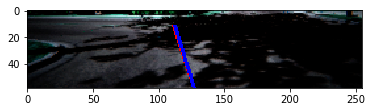

Actual Steering Angle = [0.71133567]
Predicted Steering Angle = [0.6459246]
L1 Error: [0.06541104]


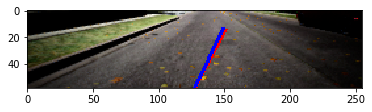

Actual Steering Angle = [0.114963]
Predicted Steering Angle = [0.20554498]
L1 Error: [0.09058198]


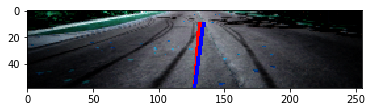

Actual Steering Angle = [-0.237892]
Predicted Steering Angle = [-0.29033506]
L1 Error: [0.05244306]


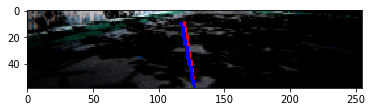

Actual Steering Angle = [-0.84491633]
Predicted Steering Angle = [-0.54783463]
L1 Error: [0.2970817]


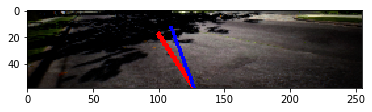

Actual Steering Angle = [0.16739933]
Predicted Steering Angle = [0.1099277]
L1 Error: [0.05747163]


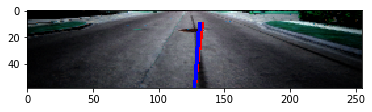

Actual Steering Angle = [-0.328315]
Predicted Steering Angle = [-0.2658691]
L1 Error: [0.06244589]


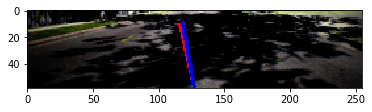

Actual Steering Angle = [-0.16900167]
Predicted Steering Angle = [-0.14661992]
L1 Error: [0.02238175]


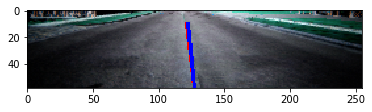

In [9]:
[sample_batch_train_data, sample_batch_test_data] = next(train_generator)
predictions = model.predict([sample_batch_train_data[0], sample_batch_train_data[1]])
for i in range(0, 8, 1):
    draw_image_with_label(sample_batch_train_data[0][i], sample_batch_test_data[i], predictions[i])

Looks good! Let's move on to actually running the model with AirSim in the [next notebook](TestModel.ipynb).